# Typical Time History of Solar Power Production at UIUC

Please see the ``README`` for instructions about accessing the data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform

## Upload datasets

df_201* is the solar irradiance data

farm_201* refers to real solar farm data

## How to handle missing data

1. Upload the solar farm datasets
2. Resample by hourly mean

Doing this will create space for the missing time by filling with NaNs. 

3. Upload the solar irradiance datasets
4. Calculate power based on the solar irradiance for each year. 

Now we can combine the datasets such that where the solar farm dataset has NaN values, it will be replaced by a calculated value from the irradiance dataset. 

In [2]:
# define path to data
path = "../../data/" 

In [3]:
# solar irradiation data
df_2016 = pd.read_csv(path+"2016_dni.csv", skiprows=2, usecols=['Year','Month','Day','Hour', 'Minute','DHI', 'DNI', 'Temperature'])
df_2016['time'] = pd.to_datetime(df_2016[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_2016.index = pd.to_datetime(df_2016.time)

df_2017 = pd.read_csv(path+"2017_dni.csv", skiprows=2, usecols=['Year','Month','Day','Hour', 'Minute','DHI', 'DNI', 'Temperature'])
df_2017['time'] = pd.to_datetime(df_2017[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_2017.index = pd.to_datetime(df_2017.time)

df_2018 = pd.read_csv(path+"2018_dni.csv", skiprows=2, usecols=['Year','Month','Day','Hour', 'Minute','DHI', 'DNI', 'Temperature'])
df_2018['time'] = pd.to_datetime(df_2018[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df_2018.index = pd.to_datetime(df_2018.time)

In [4]:
# data from the solar farm
farm_2016 = pd.read_csv(path+'solardata_2016.csv', parse_dates=True, index_col='time')
farm_2016 = farm_2016.resample('H').mean()[:8760]

farm_2017 = pd.read_csv(path+'solardata_2017.csv', parse_dates=True, index_col='time')
farm_2017 = farm_2017.resample('H').mean()

farm_2018 = pd.read_csv(path+'solardata_2018.csv', parse_dates=True, index_col='time')
farm_2018 = farm_2018.resample('H').mean()

In [5]:
len(farm_2016)

8760

In [6]:
all_data = pd.read_csv(path+"solardata.csv", parse_dates=True, index_col='time')

In [7]:
all_hourly = all_data.resample('H').mean()

In [8]:
yearly_group = all_hourly.groupby(all_hourly.index.year)

farm_2016_hourly = yearly_group.get_group(2016)[:8760]
farm_2017_hourly = yearly_group.get_group(2017)
farm_2018_hourly = yearly_group.get_group(2018)

In [9]:
farm_2018_hourly

,measured,inverted
time,,
2018-01-01 00:00:00,NaN,NaN
2018-01-01 01:00:00,NaN,NaN
2018-01-01 02:00:00,NaN,NaN
2018-01-01 03:00:00,NaN,NaN
2018-01-01 04:00:00,NaN,NaN
...,...,...
2018-12-31 19:00:00,-13.375,0.0
2018-12-31 20:00:00,-12.600,0.0
2018-12-31 21:00:00,-11.050,0.0


In [10]:
# time converters from datetime to minutes
year_minutes = lambda x: (x.year-2013)*525600 + (x.month-1)*43800  + (x.day-1)*1440 + (x.hour)*60 + x.minute
month_minutes = lambda x: (x.day-1)*1440 + (x.hour)*60 + x.minute
year_hours = lambda x: (x.year-2013)*8760 + (x.month-1)*730 + (x.day-1)*24 + (x.hour)

In [11]:
df_2016_hourly = df_2016.resample('H').mean()[:8760]
df_2017_hourly = df_2017.resample('H').mean()
df_2018_hourly = df_2018.resample('H').mean()

## Step 2: Define and calculate the declination for each day

The formula for declination is

$\delta = 23.44*\sin(\frac{\pi}{180}\frac{360}{365}(N+284))$

The factor of $\pi/180$ in the sine argument is necessary because numpy 
defaults to radians, rather than degrees.

In [12]:
# define the calculation for declination (delta). 
delta = lambda x: 23.44*np.sin(np.pi/180*(360/365)*(x+284))

In [13]:
# the deltas are still not quite correct, so I'm going to force it to be correct. 
# This will not be the prettiest of solutions. 
dec = {'delta':[]}

for day in range(1,366):
  hourly_dec = []
  for hour in range(24):
    hourly_dec.append(delta(day))
  dec['delta'].extend(hourly_dec)

dec = pd.Series(dec)
print(len(dec['delta']))

8760


In [14]:
df_2016_hourly['delta'] = dec['delta']
df_2017_hourly['delta'] = dec['delta']
df_2018_hourly['delta'] = dec['delta']

In [15]:
df_2016_hourly

,Year,Month,Day,Hour,Minute,DHI,DNI,Temperature,delta
time,,,,,,,,,
2016-01-01 00:00:00,2016.0,1.0,1.0,0.0,15.0,0.0,0.0,-6.5,-23.001824
2016-01-01 01:00:00,2016.0,1.0,1.0,1.0,15.0,0.0,0.0,-6.0,-23.001824
2016-01-01 02:00:00,2016.0,1.0,1.0,2.0,15.0,0.0,0.0,-6.0,-23.001824
2016-01-01 03:00:00,2016.0,1.0,1.0,3.0,15.0,0.0,0.0,-7.0,-23.001824
2016-01-01 04:00:00,2016.0,1.0,1.0,4.0,15.0,0.0,0.0,-8.0,-23.001824
...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,2016.0,12.0,30.0,19.0,15.0,0.0,0.0,-1.0,-23.076066
2016-12-30 20:00:00,2016.0,12.0,30.0,20.0,15.0,0.0,0.0,-0.5,-23.076066
2016-12-30 21:00:00,2016.0,12.0,30.0,21.0,15.0,0.0,0.0,0.0,-23.076066


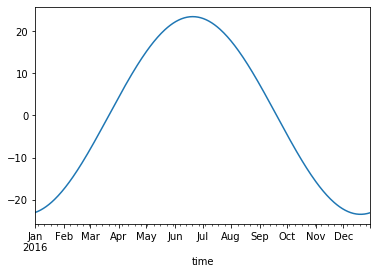

In [16]:
# verify that delta is correct
angle = df_2016_hourly['delta'].resample('D').mean()
angle.plot()

## Step 3: Calculate the hourly Total Irradiance ($G_T$) and Power (P)

This is the model for power output of a solar panel \
$P = G_T\tau_{pv}\eta_{ref}A[1-\gamma(T-25)]$

where $G_T$ is given by \
$G_T = DNI*\cos(\beta+\delta-lat)+DHI*\frac{180-\beta}{180}$

- $\tau$ is the "transmittance of the PV module's outside layer"
- $\gamma$ is the "temperature coefficient
- A is the area covered by the solar panels
- $\eta$ is the PV module efficiency
- $\beta$ is the tilt of the solar panels
- T is the temperature (in $^\circ$C)

These formulas were obtained from Garcia et. al. Which can be found at this link
https://inldigitallibrary.inl.gov/sites/sti/sti/6531825.pdf 

The values for $\gamma$, $\tau$ and $\eta$ are not known for the UIUC solar farm, thus values from Garcia et. al are also used. Later, we will normalize the data set and rescale it by the rated power to fix this problem. 

In [17]:
# approximate coordinates of champaign-urbana
lat = 40.13
lon = -88.22

# these values are from Garcia et. al
# Currently, the maximum power output is too high. 
eta = 0.15
tau = 0.9
gam = 0.0045 # changed this from 0.0045 to 0.009 to see if I get a more accurate max value.

# these values are from the iSEE facts sheet regarding UIUC's solar farm
beta = 20
A = 84174.61*0.6 # [m^2] or 20.8 acres, but a coverage factor of 60%

# define the formulae
G = lambda dni, delt, dhi: dni*np.cos((np.pi/180)*(beta + delt - lat)) + dhi*(180-beta)/180
P = lambda Gt, T: Gt*tau*eta*A*(1-gam*(T-25))

In [18]:
sol_irr = {'G':[]}
for i in range(len(df_2016_hourly)):
  dni = df_2016_hourly.iloc[i]['DNI']
  dhi = df_2016_hourly.iloc[i]['DHI']
  delt = df_2016_hourly.iloc[i]['delta']
  sol_irr['G'].append(G(dni, delt, dhi))
df_2016_hourly['G'] = sol_irr['G']

power = {'Power':[]}
for i in range(len(df_2016_hourly)):
  gt = df_2016_hourly.iloc[i]['G']
  T = df_2016_hourly.iloc[i]['Temperature']
  power['Power'].append(P(gt, T))
df_2016_hourly['power'] = power['Power']

In [19]:
sol_irr = {'G':[]}
for i in range(len(df_2017_hourly)):
  dni = df_2017_hourly.iloc[i]['DNI']
  dhi = df_2017_hourly.iloc[i]['DHI']
  delt = df_2017_hourly.iloc[i]['delta']
  sol_irr['G'].append(G(dni, delt, dhi))
df_2017_hourly['G'] = sol_irr['G']

power = {'Power':[]}
for i in range(len(df_2017_hourly)):
  gt = df_2017_hourly.iloc[i]['G']
  T = df_2017_hourly.iloc[i]['Temperature']
  power['Power'].append(P(gt, T))
df_2017_hourly['power'] = power['Power']

In [20]:
sol_irr = {'G':[]}
for i in range(len(df_2018_hourly)):
  dni = df_2018_hourly.iloc[i]['DNI']
  dhi = df_2018_hourly.iloc[i]['DHI']
  delt = df_2018_hourly.iloc[i]['delta']
  sol_irr['G'].append(G(dni, delt, dhi))
df_2018_hourly['G'] = sol_irr['G']

power = {'Power':[]}
for i in range(len(df_2018_hourly)):
  gt = df_2018_hourly.iloc[i]['G']
  T = df_2018_hourly.iloc[i]['Temperature']
  power['Power'].append(P(gt, T))
df_2018_hourly['power'] = power['Power']

In [21]:
# import required libraries to normalize
from sklearn import preprocessing

def normalize(df, col):
  """
  This function accepts a dataframe and a column label
  and returns a normalized version of the column as a 
  pandas series.

  Parameters:
  -----------
  df : Pandas dataframe
    The dataframe containing the column you'd like to normalize.
  col : string
    The label of the column you wish to normalize

  Returns: 
  --------
  normalized_col : Pandas series
    The normalized column of data.
  """
  column = df[[col]].values.astype(float)
  min_max_scaler = preprocessing.MinMaxScaler()
  column_scaled = min_max_scaler.fit_transform(column)
  
  normalized_col = pd.Series({col+'_norm':column_scaled})

  return normalized_col

In [22]:
rated_power = 4.8*1000 # [MWe]
norm_2016 = normalize(df_2016_hourly, 'power')
df_2016_hourly['power_norm'] = norm_2016['power_norm']*rated_power

norm_2017 = normalize(df_2017_hourly, 'power')
df_2017_hourly['power_norm'] = norm_2017['power_norm']*rated_power

norm_2018 = normalize(df_2018_hourly, 'power')
df_2018_hourly['power_norm'] = norm_2018['power_norm']*rated_power

In [23]:
df_2018_hourly.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,Temperature,delta,G,power,power_norm
time,,,,,,,,,,,,
2018-01-01 00:00:00,2018.0,1.0,1.0,0.0,15.0,0.0,0.0,-21.10,-23.001824,0.0,0.0,0.0
2018-01-01 01:00:00,2018.0,1.0,1.0,1.0,15.0,0.0,0.0,-21.80,-23.001824,0.0,0.0,0.0
2018-01-01 02:00:00,2018.0,1.0,1.0,2.0,15.0,0.0,0.0,-22.50,-23.001824,0.0,0.0,0.0
2018-01-01 03:00:00,2018.0,1.0,1.0,3.0,15.0,0.0,0.0,-23.15,-23.001824,0.0,0.0,0.0
2018-01-01 04:00:00,2018.0,1.0,1.0,4.0,15.0,0.0,0.0,-23.75,-23.001824,0.0,0.0,0.0


In [24]:
farm_2018_hourly.head()

,measured,inverted
time,,
2018-01-01 00:00:00,NaN,NaN
2018-01-01 01:00:00,NaN,NaN
2018-01-01 02:00:00,NaN,NaN
2018-01-01 03:00:00,NaN,NaN
2018-01-01 04:00:00,NaN,NaN


In [25]:
df_2016_hourly['power_data'] = farm_2016_hourly['inverted']
df_2017_hourly['power_data'] = farm_2017_hourly['inverted']
df_2018_hourly['power_data'] = farm_2018_hourly['inverted']

df_2018_hourly.head()

,Year,Month,Day,Hour,Minute,DHI,DNI,Temperature,delta,G,power,power_norm,power_data
time,,,,,,,,,,,,,
2018-01-01 00:00:00,2018.0,1.0,1.0,0.0,15.0,0.0,0.0,-21.10,-23.001824,0.0,0.0,0.0,NaN
2018-01-01 01:00:00,2018.0,1.0,1.0,1.0,15.0,0.0,0.0,-21.80,-23.001824,0.0,0.0,0.0,NaN
2018-01-01 02:00:00,2018.0,1.0,1.0,2.0,15.0,0.0,0.0,-22.50,-23.001824,0.0,0.0,0.0,NaN
2018-01-01 03:00:00,2018.0,1.0,1.0,3.0,15.0,0.0,0.0,-23.15,-23.001824,0.0,0.0,0.0,NaN
2018-01-01 04:00:00,2018.0,1.0,1.0,4.0,15.0,0.0,0.0,-23.75,-23.001824,0.0,0.0,0.0,NaN


In [26]:
# first replace power_data 
df_2016_hourly.power_data.fillna(df_2016_hourly.power_norm, inplace=True)
df_2017_hourly.power_data.fillna(df_2017_hourly.power_norm, inplace=True)
df_2018_hourly.power_data.fillna(df_2018_hourly.power_norm, inplace=True)

# then replace power_norm
df_2016_hourly.power_norm.fillna(0, inplace=True)
df_2017_hourly.power_norm.fillna(0, inplace=True)
df_2018_hourly.power_norm.fillna(0, inplace=True)

4799.999999999999
4731.0


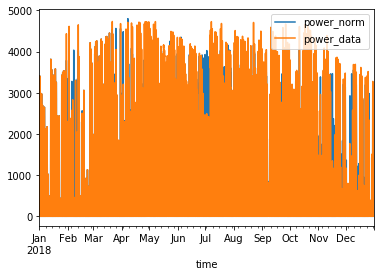

In [27]:
final_2018 = df_2018_hourly[['power_norm','power_data']]
print(final_2018.power_norm.max())
print(final_2018.power_data.max())
final_2018.plot()

In [28]:
final_2016 = df_2016_hourly[['power_norm','power_data']]
final_2017 = df_2017_hourly[['power_norm','power_data']]

In [29]:
%%capture
# convert time to hour number


final_2016.reset_index(inplace=True)
final_2017.reset_index(inplace=True)
final_2018.reset_index(inplace=True)

final_2016['time'] = final_2016.index
final_2017['time'] = final_2017.index
final_2018['time'] = final_2018.index

## Execute RAVEN simulation

In [30]:
final_2016

,time,power_norm,power_data
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
8755,8755,0.0,0.0
8756,8756,0.0,0.0
8757,8757,0.0,0.0
8758,8758,0.0,0.0


In [31]:
# writes the header file for RAVEN
fname = 'annual_sun201'
sun_keys = [fname + str(i) + '.csv' for i in range(6,9,1)]
header_file = pd.DataFrame({'scaling':np.zeros(len(sun_keys), dtype=np.int8), 'filename':sun_keys})
header_file.to_csv(path+'annual_sun_H.csv')
# header_file

In [32]:
final_2016.to_csv(path+'annual_sun2016.csv')
final_2017.to_csv(path+'annual_sun2017.csv')
final_2018.to_csv(path+'annual_sun2018.csv')

In [33]:
if platform.system() == 'Windows':
    !git-bash %userprofile%/research/raven/raven_framework %userprofile%/research/pride/inputfiles/typical_solar.xml
else:
    !~/research/raven/raven_framework ~/research/pride/inputfiles/typical_solar.xml

CONDA
raven_libraries          /home/dotson/anaconda3/envs/raven_libraries
Running RAVEN in "opt" mode.
PluginFactory: No installed plugins detected.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      .---.        .------######       #####     ###   ###  ########  ###    ###
     /     \  __  /    --###  ###    ###  ###   ###   ###  ###       #####  ###
    / /     \(  )/    --###  ###    ###   ###  ###   ###  ######    ### ######
   //////   ' \/ `   --#######     #########  ###   ###  ###       ###  #####
  //// / // :    :   -###   ###   ###   ###    ######   ####      ###   ####
 // /   /  /`    '---###    ###  ###   ###      ###    ########  ###    ###
//          //..\
===========UU====UU=============================================================
           '//||\`
             ''``
    

Copyright 2017 Battelle Energy Alliance, LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in complian

(    1.06 sec) PostProcessor            : DEBUG           -> InterfacedPostProcessor Post-Processor typicalHistory : start to run
(    1.16 sec) STEP SINGLERUN           : Message         -> ***       Run finished        ***
(    1.16 sec) STEP SINGLERUN           : Message         -> ***     Closing the step      ***
(    1.16 sec) STEP SINGLERUN           : Message         -> ***        Step closed        ***
(    1.16 sec) SIMULATION               : Message         -> -- End step get_history of type: PostProcess                   --

(    1.16 sec) SIMULATION               : Message         -> -- Beginning step write of type: IOStep                             --
(    1.16 sec) STEP IOCOMBINED          : Message         -> ***  Beginning initialization ***
(    1.16 sec) STEP IOCOMBINED          : DEBUG           -> jobHandler initialized
(    1.16 sec) STEP IOCOMBINED          : DEBUG           -> for the role Output the item of class OutStreamPrint  and name TypicalSolar    has be

In [34]:
typical_solar = pd.read_csv(path+"TypicalSolar_0.csv")

typical_solar['date'] = pd.date_range(start='1/1/2018', end='1/1/2019', freq='H')[:8760]

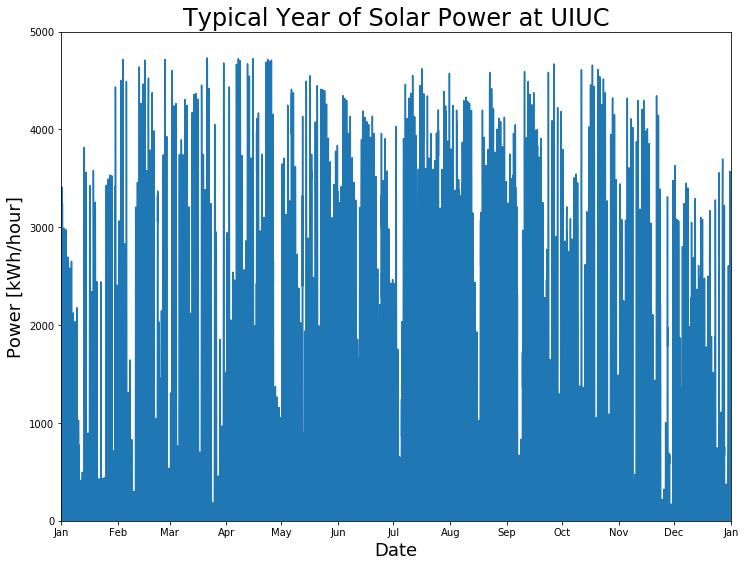

In [35]:
import matplotlib.dates as mdates
import datetime


# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

fig,ax = plt.subplots(1,1,figsize=(12,9), edgecolor='k', facecolor='w')
ax.plot(typical_solar.date, typical_solar.power_data)
ax.set_title('Typical Year of Solar Power at UIUC', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Power [kWh/hour]',fontsize=18)
ax.set_xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
ax.set_ylim(0, 5000)
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()

In [36]:
print("Average typical solar power is {}".format(typical_solar.power_data.mean()))

Average typical solar power is 884.1104533829059


### Constructing the ARMA

Following the lessons learned from generating ``demand_arma.xml``. 

#### Lessons Learned
There was an issue of the ARMA returning non-physical results (a hump in the summer months where the power never went to zero and going negative in the winter months). The solution to this was to use the options in the ``ARMA`` class:

``<ZeroFilter>variableName</ZeroFilter>``

and


``<outTruncation domain="positive">variableName</outTruncation>``

The ``<outTruncation>`` method forces any negative values to be zero. Paul Talbot from INL gave a nice explanation for this phenomenon. There is an assumption that residual noise after Fourier detrending is uniformly stochastic. The variance is higher during the middle part of the day but is also added/subtracted from the early and late hours of the day when the sun is lowest in the sky (thus producing the least power, non-zero, power). Therefore, forcing the negative values to be zero is a reasonable thing to do. 

In [37]:
if platform.system() == 'Windows':
    !git-bash %userprofile%/research/raven/raven_framework %userprofile%/research/pride/inputfiles/solar_arma.xml
else:
    !~/research/raven/raven_framework ~/research/pride/inputfiles/solar_arma.xml

CONDA
raven_libraries          /home/dotson/anaconda3/envs/raven_libraries
Running RAVEN in "opt" mode.
PluginFactory: No installed plugins detected.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      .---.        .------######       #####     ###   ###  ########  ###    ###
     /     \  __  /    --###  ###    ###  ###   ###   ###  ###       #####  ###
    / /     \(  )/    --###  ###    ###   ###  ###   ###  ######    ### ######
   //////   ' \/ `   --#######     #########  ###   ###  ###       ###  #####
  //// / // :    :   -###   ###   ###   ###    ######   ####      ###   ####
 // /   /  /`    '---###    ###  ###   ###      ###    ########  ###    ###
//          //..\
===========UU====UU=============================================================
           '//||\`
             ''``
    

Copyright 2017 Battelle Energy Alliance, LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in complian

(    1.06 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/research/data/TypicalSolar_0.csv.csv"
(    1.07 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    1.07 sec) STEP IOCOMBINED          : Message         -> ***     Closing the step      ***
(    1.07 sec) STEP IOCOMBINED          : Message         -> ***        Step closed        ***
(    1.07 sec) SIMULATION               : Message         -> -- End step read of type: IOStep                               --

(    1.07 sec) SIMULATION               : Message         -> -- Beginning step trainARMA of type: RomTrainer                     --
(    1.07 sec) STEP ROM TRAINER         : Message         -> ***  Beginning initialization ***
(    1.07 sec) STEP ROM TRAINER         : DEBUG           -> jobHandler initialized
(    1.07 sec) STEP ROM TRAINER         : Message         -> ***    Initialization done    ***
(    1.07 sec) STEP ROM TRAINER         : Message 

(  209.16 sec) STEP MULTIRUN            : DEBUG           -> Just collected job    10    and sent to output "synHist"
(  209.16 sec) STEP MULTIRUN            : DEBUG           -> Testing if the sampler is ready to generate a new input
(  209.16 sec) MonteCarlo               : DEBUG           -> Sampling limit reached! No new samples ...
(  209.16 sec) STEP MULTIRUN            : DEBUG           ->  ... sampler has no new inputs currently.
(  209.16 sec) MonteCarlo               : DEBUG           -> Sampling limit reached! No new samples ...
(  209.16 sec) STEP MULTIRUN            : DEBUG           -> Sampling finished with 10 runs submitted, 0 jobs running, and 0 completed jobs waiting to be processed.
(  209.16 sec) MonteCarlo               : DEBUG           -> ===============
(  209.16 sec) MonteCarlo               : DEBUG           -> | RUN SUMMARY |
(  209.16 sec) MonteCarlo               : DEBUG           -> ===============
(  209.16 sec) MonteCarlo               : DEBUG           

In [38]:
synthetic_history = pd.read_csv(path+"solarHistories_2.csv")

Text(0.5, 1.0, 'Synthetic and Typical Solar Power Histories')

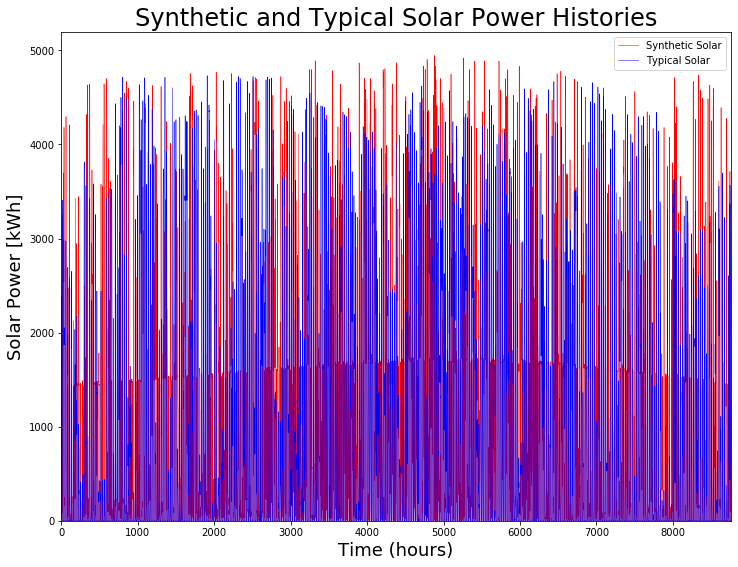

In [39]:
# plot synthetic history
fig,ax = plt.subplots(1,1,figsize=(12,9), edgecolor='k', facecolor='w')
ax.plot(synthetic_history['time'], synthetic_history['power_data'], 
         color='r',lw = 0.5, label='Synthetic Solar')
ax.plot(typical_solar['time'], typical_solar['power_data'], 
         color='b', lw=0.5, label='Typical Solar')
ax.set_ylabel("Solar Power [kWh]", fontsize=18)
ax.set_xlabel("Time (hours)", fontsize=18)
ax.set_ylim(0,5200)
ax.set_xlim(0,8760)
ax.legend()
ax.set_title("Synthetic and Typical Solar Power Histories", fontsize=24)